# Agentic RAG with LangGraph, TogetherAI for understanding Startup Equity

Author: [Ajay Krishnan](https://x.com/Aj_Krish23)

A typical Retrieval-Augmented Generation (RAG) setup works like this: take the user's question, fetch a handful of documents in a single retrieval step, and pass them to the LLM to craft a response based on that context.

This is a solid starting point, but it comes with some important trade-offs.

If the retrieval step misses key information, or brings back noisy results, the final output from the LLM will inevitably be affected. Even if you swap in a stronger embedding model, try out hybrid techniques or retrieve more documents — you're still locked into a one-shot retrieval based solely on the user's original query.

For simple questions, that might be enough. But for more complex queries, this approach can start to break down.

---


In this notebook, we'll explore a smarter RAG pattern — one where the system can actively guide itself to find better answers.

The Agentic RAG system we'll build will be able to:

- **Reframe** the initial question if needed to make retrieval more effective.
- **Evaluate** whether the retrieved context is good enough.
- **Take additional actions** to gather more information when necessary.

This gives our application a feedback loop - the ability to pause, think, and iterate — which makes it much better equipped to handle tricky or multi-part questions.

---

To put this idea into practice, we'll use **[LangGraph](https://github.com/langchain-ai/langgraph)** — a flexible framework designed for creating multi-step reasoning flows and **[TogetherAI](https://www.together.ai/)** - an inference provider for all things LLMs.

LangGraph lets us define agents as graphs of interconnected nodes, making it easy to model decision-making, retrieval, and generation all in one place.

You don't need any previous experience with graph-based agents — we'll walk through everything step by step.

Let's jump in!



# Preparing the Data

In this tutorial, we’ll be working with a small collection of documents focused on startup equity and founder agreements. These include resources like *Equity for Founders* by Stripe Atlas, *Founders' Collaboration Agreements* from the Penn Law ELC, *How to Split Equity Among Startup Cofounders* by Stripe, and a guide on *Startup Incorporation for Founders* by Clerky.

These documents provide a wide range of practical advice—from understanding how founder equity works, to navigating early-stage agreements between cofounders, to best practices for incorporation. All files are in PDF format and were pre-uploaded to an Amazon S3 bucket for this project.


Every RAG application begins with data — and more often than not, that data is **unstructured**.  
Think PDFs, Word documents, emails, SharePoint files, and more.

Turning these raw sources into clean, retrieval-ready chunks is a critical first step — but it can quickly become a complex and messy process.

That's where the **[Unstructured](https://unstructured.io/)** comes in.

Unstructured makes it easy to:

- Connect to a wide variety of data sources.
- Preprocess and transform raw files into structured formats.
- Push the processed data directly into the database/vector store of your choice.

In this notebook, we'll programmatically work with Unstructured by tapping into the **Workflow Endpoint** — a powerful interface that lets you define entire pipelines through code.

With Unstructured API, you will set up a workflow by:

* Creating an S3 _source connector_ in Unstructured API to connect it to the documents
* Creating an AstraDB _destination connector_ in Unstructured API to upload the processed documents
* Creating a _workflow_ that starts with a source connector, adds data transformation steps (such as extracting content of the PDFs with Anthropic Claude Sonnet, enriching the documents with metadata, chunking the text, and generating embedding vectors for the similarity search), and then ends with uploading the results into the destination.

all without leaving this colab notebook.

Before we dive in, make sure to **[sign up for Unstructured for Developers](https://unstructured.io/developers)** to access the platform and get your API credentials ready.





In [ ]:
!pip install -U "unstructured-client"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.4/189.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 16.7 MB/s eta 0:00:00


In [ ]:
import os
import time
from google.colab import userdata
from unstructured_client import UnstructuredClient


def pretty_print_model(response_model):
    print(response_model.model_dump_json(indent=4))

In [ ]:
os.environ['UNSTRUCTURED_API_KEY'] = userdata.get('UNSTRUCTURED_API_KEY')
client = UnstructuredClient(api_key_auth=os.getenv("UNSTRUCTURED_API_KEY"))

## Setting up the S3 Source Connector


For this demo, we will be using AWS Key and Secret for Authentication.
Make sure to add fetch the corresponding values and for `S3_AWS_KEY` and `S3_AWS_SECRET` and add to the Secrets in Colab.


Similarly, fetch the the S3 URI to the bucket or folder, formatted as `s3://my-bucket/` (if the files are in the bucket's root) or `s3://my-bucket/my-folder/` and add it to `S3_REMOTE_URL` in the Secrets.





For other authentication options and more details refer to [this](https://docs.unstructured.io/platform/api/sources/s3).

In [ ]:
os.environ['S3_AWS_KEY'] = userdata.get('S3_AWS_KEY')
os.environ['S3_AWS_SECRET'] = userdata.get('S3_AWS_SECRET')
os.environ['S3_REMOTE_URL'] = userdata.get('S3_REMOTE_URL')

In [ ]:
from unstructured_client.models.operations import CreateSourceRequest
from unstructured_client.models.shared import (
    CreateSourceConnector,
    SourceConnectorType,
    S3SourceConnectorConfigInput
)

source_response = client.sources.create_source(
    request=CreateSourceRequest(
        create_source_connector=CreateSourceConnector(
            name=f"law_rag_s3_source_{time.time()}",
            type=SourceConnectorType.S3,
            config=S3SourceConnectorConfigInput(
                key=os.environ.get('S3_AWS_KEY'),
                secret=os.environ.get('S3_AWS_SECRET'),
                remote_url=os.environ.get('S3_REMOTE_URL'),
                recursive=True
            )
        )
    )
)

In [ ]:
pretty_print_model(source_response.source_connector_information)

{
    "config": {
        "anonymous": false,
        "recursive": true,
        "remote_url": "s3://ajay-uns-devrel-content/legal-rag-content/",
        "key": "**********",
        "secret": "**********"
    },
    "created_at": "2025-04-29T18:49:55.227890Z",
    "id": "3acf6171-2cee-4da6-9fe5-9a05e8a3d7ec",
    "name": "law_rag_s3_source_1745952594.920226",
    "type": "s3",
    "updated_at": "2025-04-29T18:49:56.094829Z"
}


## Setting up the Astra DB Destination Connector

Create an account on [datastax.com](https://www.datastax.com/), and create a new Serverless (Vector) Database. Once it's instantiated, grab your credentials - API endpoint, and an application token,- and save them. If you need help getting started with AstraDB, refer to [their documentation](https://docs.datastax.com/en/astra-db-serverless/get-started/quickstart.html).

In the database, create a collection. Give it a name, then in the embedding generation method choose `Bring my own` as we will generate the embeddings automatically with Unstructured. The dimensions value should be set to ``768`` in this example as we'll be using [`"m2-bert-80M-8k-retrieval"` model from TogetherAI](https://www.together.ai/models/m2-bert-80m-8k-retrieval).


Add the Application Token, API Endpoint, Collection Name and Keyspace to secrets.
More documentation [here](https://docs.unstructured.io/platform/api/destinations/astradb).


Grabbing these from the Secrets stored in the Colab notebook:

In [ ]:
os.environ['ASTRA_DB_API_ENDPOINT'] = userdata.get('ASTRA_DB_API_ENDPOINT')
os.environ['ASTRA_DB_APPLICATION_TOKEN'] = userdata.get('ASTRA_DB_APPLICATION_TOKEN')
os.environ['ASTRA_DB_COLLECTION_NAME'] = userdata.get('ASTRA_DB_COLLECTION_NAME')
os.environ['ASTRA_DB_KEYSPACE'] = userdata.get('ASTRA_DB_KEYSPACE')

In [ ]:
from unstructured_client.models.operations import CreateDestinationRequest
from unstructured_client.models.shared import (
    CreateDestinationConnector,
    DestinationConnectorType,
    AstraDBConnectorConfigInput
)
destination_response = client.destinations.create_destination(
    request=CreateDestinationRequest(
        create_destination_connector=CreateDestinationConnector(
            name=f"astra_destination_{time.time()}",
            type=DestinationConnectorType.ASTRADB,
            config=AstraDBConnectorConfigInput(
                token=os.environ.get('ASTRA_DB_APPLICATION_TOKEN'),
                api_endpoint=os.environ.get('ASTRA_DB_API_ENDPOINT'),
                collection_name=os.environ.get('ASTRA_DB_COLLECTION_NAME'),
                keyspace=os.environ.get('ASTRA_DB_KEYSPACE'),
                batch_size=20,
                flatten_metadata=False
            )
        )
    )
)

In [ ]:
pretty_print_model(destination_response.destination_connector_information)

{
    "config": {
        "api_endpoint": "**********",
        "batch_size": 20,
        "collection_name": "demo3",
        "token": "**********",
        "keyspace": "demo3"
    },
    "created_at": "2025-04-29T18:49:57.548395Z",
    "id": "a5f42657-ffbf-462f-8319-f1d51d78f541",
    "name": "astra_destination_1745952597.499409",
    "type": "astradb",
    "updated_at": "2025-04-29T18:49:58.377096Z"
}


### Creating a Document Processing Workflow

Now that we have access to our data, the next step is setting up how it should be processed.

We'll define a simple but powerful document pipeline using three key types of processing nodes:

- **Partitioner**  
  This step takes raw, unstructured files and extracts structured content from them.  
  We'll use a **Vision-Language Model (VLM) Partitioner**, which leverages a model capable of understanding both text and layout information from documents — pulling out elements from each page with higher fidelity.

- **Chunker**  
  After partitioning, the extracted elements are grouped into manageable "chunks."  
  Chunking ensures that during retrieval, we can focus only on the most relevant sections of a document — not the whole thing.

- **Embedder**  
  Finally, we'll generate vector embeddings for each chunk of text.  
  Embeddings are numeric representations that capture the meaning of the text, making it searchable and retrievable later on. We'll rely on an embedding provider to handle this step for us.

Each node plays a critical role in making our documents **retrieval-ready** for downstream RAG applications.

If you're curious about the different configuration options available for these processing steps, you can explore more details in the [Concepts documentation](https://docs.unstructured.io/ui/document-elements).


In [ ]:
from unstructured_client.models.shared import (
    WorkflowNode,
    WorkflowType,
    Schedule
)

parition_node = WorkflowNode(
    name="Partitioner",
    subtype="vlm",
    type="partition",
    settings={
        "provider": "anthropic",
        "model": "claude-sonnet-4-5-20250929",
        }
    )

chunk_node = WorkflowNode(
    name="Chunker",
    subtype="chunk_by_title",
    type="chunk",
    settings={
        "new_after_n_chars": 1000,
        "max_characters": 1200,
        "overlap": 150
    }
)

embedder_node = WorkflowNode(
    name='Embedder',
    subtype='togetherai',
    type="embed",
    settings={
        'model_name': 'togethercomputer/m2-bert-80M-8k-retrieval'
        }
    )


response = client.workflows.create_workflow(
    request={
        "create_workflow": {
            "name": f"S3 to Astra AgenticRAG_{time.time()}",
            "source_id": source_response.source_connector_information.id,
            "destination_id": destination_response.destination_connector_information.id,
            "workflow_type": WorkflowType.CUSTOM,
            "workflow_nodes": [
                parition_node,
                chunk_node,
                embedder_node
            ]
        }
    }
)

pretty_print_model(response.workflow_information)
workflow_id = response.workflow_information.id

When it's all set up, your workflow should look something like this.

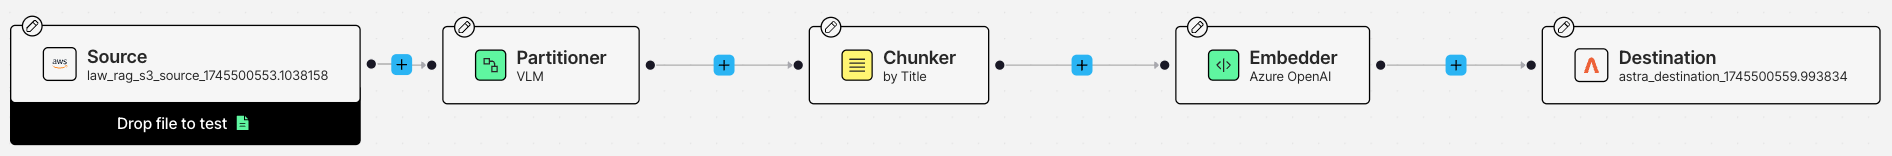

## Running the workflow

Now that we've defined how we want to process our documentation, let's start the workflow and wait for it to complete:

In [ ]:
res = client.workflows.run_workflow(
    request={
        "workflow_id": workflow_id,
    }
)

pretty_print_model(res.job_information)

{
    "created_at": "2025-04-29T18:50:03.348884Z",
    "id": "7e6a8dca-dc18-4194-9cd7-9d6fcd7dd4ea",
    "status": "SCHEDULED",
    "workflow_id": "5ba24afb-e35c-4842-a374-94c10644d203",
    "workflow_name": "S3 to Astra AgenticRAG_1745952598.4844024"
}


In [ ]:
response = client.jobs.list_jobs(
    request={
        "workflow_id": workflow_id
    }
)

last_job = response.response_list_jobs[0]
job_id = last_job.id
print(f"job_id: {job_id}")

job_id: 7e6a8dca-dc18-4194-9cd7-9d6fcd7dd4ea


Now that we've created and started a job, we can poll Unstructured's `get_job` endpoint and check for its status every 30s till completion

In [ ]:
import time

def poll_job_status(job_id, wait_time=30):
    while True:
        response = client.jobs.get_job(
            request={
                "job_id": job_id
            }
        )

        job = response.job_information

        if job.status == "SCHEDULED":
            print(f"Job is scheduled, polling again in {wait_time} seconds...")
            time.sleep(wait_time)
        elif job.status == "IN_PROGRESS":
            print(f"Job is in progress, polling again in {wait_time} seconds...")
            time.sleep(wait_time)
        else:
            print("Job is completed")
            break

    return job

job = poll_job_status(job_id)
pretty_print_model(job)

Job is scheduled, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is completed
{
    "created_at": "2025-04-29T18:50:03.348884",
    "id": "7e6a8dca-dc18-4194-9cd7-9d6fcd7dd4ea",
    "status": "COMPLETED",
    "workflow_id": "5ba24afb-e35c-4842-a374-94c10644d203",
    "workflow_name": "S3 to Astra AgenticRAG_1745952598.4844024",
    "runtime": "PT0S"
}


At this point, we've completed all the foundational steps:

- Extracted structured elements from raw documents using a **Partitioner**.
- Organized the extracted content into manageable chunks with a **Chunker**.
- Generated vector embeddings for those chunks through an **Embedder**.

Our processed data is now stored and ready for retrieval.

Next, we'll connect the pieces together and build a RAG pipeline that can answer questions grounded in this freshly structured knowledge base.



# RAG 🤖


### Requirements

For this project, you'll need the following libraries:

- `astrapy` — Python client for working with Astra DB, which we'll use to store and retrieve vector embeddings.
- `langgraph` — A flexible framework for building agentic workflows and graphs of reasoning steps.
- `grandalf` — A graph manipulation library used internally by LangGraph for building and managing computational graphs.

We'll install all these libraries up front to make sure everything is ready to go.


In [ ]:
!pip install -U astrapy langgraph grandalf together

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.9/148.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 14.6 MB/s eta 0:00:00


Before we can start making API calls, we need to set our API keys from the `userdata` configuration.

Before we can use Together AI models, we'll need an API key.

You can get your Together AI API key by following these steps:

1. Go to [https://together.ai/](https://together.ai/) and sign up for a free account.
2. After logging in, navigate to the **API Keys** section in the dashboard.
3. Create a new API key and copy it — you'll need it for authentication.

Fetching the Together AI API key from the secrets!


In [ ]:
os.environ["TOGETHER_API_KEY"] = userdata.get("TOGETHER_API_KEY")

In [ ]:
from typing import List, Dict, TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from astrapy import DataAPIClient
from together import Together

Let's use the newly released Llama-4 Maverick as the LLM for generation

In [ ]:
together_client = Together()
EMBEDDING_MODEL = "togethercomputer/m2-bert-80M-8k-retrieval"
GENERATION_MODEL = "meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8"
TOP_K = 3

Establish connection to Astra DB

In [ ]:
astra_client = DataAPIClient(os.environ["ASTRA_DB_APPLICATION_TOKEN"])
database = astra_client.get_database(os.environ["ASTRA_DB_API_ENDPOINT"])
COLLECTION = database.get_collection(
    name=os.environ["ASTRA_DB_COLLECTION_NAME"],
    keyspace=os.environ["ASTRA_DB_KEYSPACE"]

)

Utility Functions

- `get_embedding(text: str)`:  
  Generates an embedding vector for a given text.

- `simple_retriever(query: str, n: int) -> str`:  
  Retrieves the top `n` documents most similar to a query based on embedding similarity.

- `invoke_RAG(chain, question)`:  
  Sends a question to a chain (like a LangGraph agent) and prints the final generated answer.


In [ ]:
def get_embedding(text: str):
    response = together_client.embeddings.create(
      model = EMBEDDING_MODEL,
      input = text
    )

    return response.data[0].embedding

def simple_retriever(query: str, n: int = TOP_K) -> str:
    embedding = get_embedding(query)
    results = COLLECTION.find(sort={"$vector": embedding}, limit=n)
    docs = [doc["content"] for doc in results]
    return "\n".join(f"===== Document {i+1} =====\n{doc}" for i, doc in enumerate(docs))

def invoke_RAG(chain, question):
  result = chain.invoke({"question": question})
  print("\n Final Answer:\n", result["answer"])

## Defining Vanilla RAG with Langgraph

LangGraph lets us build reasoning workflows by connecting functions (called nodes) into a graph structure.  
Each function updates a shared state dictionary as the data flows from one step to the next.  
This approach makes it easy to model multi-step logic.


Here’s a quick overview of what each function in our graph is responsible for:

- `retrieve_node(state: VanillaRAGState)`:  
  Takes the user's question, retrieves the most relevant documents, and stores them into the `"docs"` field of the shared state.

- `generate_node(state: VanillaRAGState)`:  
  Takes the retrieved documents along with the original question, creates a prompt, sends it to the Together AI API, and saves the model's answer into the `"answer"` field of the state.





In [ ]:
class VanillaRAGState(TypedDict, total=False):
    question: str
    docs: str
    answer: str

def retrieve_node(state: VanillaRAGState) -> Dict:
    docs = simple_retriever(state["question"])
    return {"docs": docs}


def generate_node(state: VanillaRAGState) -> Dict:
    question, context = state["question"], state["docs"]
    prompt = (
        "You are an assistant that answers questions using the provided context only.\n"
        "Do not speculate. If insufficient data, say so.\n"
        f"Question: {question}\n"
        f"Context:\n{context}"
    )
    response = together_client.chat.completions.create(
          model=GENERATION_MODEL,
          messages=[
              {"role": "system", "content": "Follow the instructions strictly."},
              {"role": "user", "content": prompt},
              ],
          temperature=0
    )
    return {"answer": response.choices[0].message.content.strip()}

vanilla_graph = StateGraph(VanillaRAGState)

vanilla_graph.add_node("retrieve", retrieve_node)
vanilla_graph.add_node("generate", generate_node)

vanilla_graph.add_edge(START, "retrieve")
vanilla_graph.add_edge("retrieve", "generate")
vanilla_graph.add_edge("generate", END)

vanilla_rag_chain = vanilla_graph.compile()


In our graph setup:

1. We start at the `"retrieve"` node, where we pull documents based on the question.
2. The retrieved docs are passed along to the `"generate"` node, which creates the final answer.
3. After generation, the graph execution ends.

By wiring these nodes together, LangGraph handles the flow automatically — moving from retrieval to generation based on the state transitions we defined.

In [ ]:
vanilla_rag_chain.get_graph().print_ascii()

+-----------+  
| __start__ |  
+-----------+  
      *        
      *        
      *        
+----------+   
| retrieve |   
+----------+   
      *        
      *        
      *        
+----------+   
| generate |   
+----------+   
      *        
      *        
      *        
 +---------+   
 | __end__ |   
 +---------+   


Now lets test it with some questions

In [ ]:
query = 'Create a negotiation playbook for a founder trying to change a 4-year cliff vesting into milestone-based vesting with partial upfront equity.'

invoke_RAG(vanilla_rag_chain, query)


 Final Answer:
 To create a negotiation playbook for a founder trying to change a 4-year cliff vesting into milestone-based vesting with partial upfront equity, we need to understand the context and the motivations of both the founder and the investors.

From the provided context, we can infer the following:

1. **Vesting is a common practice**: Investors and savvy cofounders often require vesting as a condition of doing business (Document 2). This implies that investors are likely to be hesitant to change the vesting schedule.
2. **Founders may be subject to acceleration**: Acceleration clauses can be included in contracts to allow for faster vesting under certain conditions (Document 3). This could be a potential bargaining chip for the founder.
3. **Single-trigger and double-trigger acceleration**: Founders tend to prefer single-trigger acceleration, while VCs in Silicon Valley generally prefer double-trigger acceleration (Document 1). This indicates that there may be a difference 

In [ ]:
query = 'What are corp statuses?'

invoke_RAG(vanilla_rag_chain, query)


 Final Answer:
 Insufficient data. The term "corp statuses" is not mentioned in the provided context.


The retrieved chunks did not have enough context to help answer the question.
Lets also test it with a question that involves comparisons with multiple sources

In [ ]:
query = 'How do the vesting schedules (cliff length, monthly cadence) and single- vs double-trigger acceleration clauses recommended for founders differ between Stripe Atlas and the UPenn sample Founders’ Agreement, and which would best protect a solo founder planning to sell within 3 years?'

invoke_RAG(vanilla_rag_chain, query)


 Final Answer:
 To answer the question, we need to analyze the vesting schedules and acceleration clauses in Stripe Atlas and the UPenn sample Founders' Agreement.

Unfortunately, the provided context does not directly mention Stripe Atlas's vesting schedules and acceleration clauses. However, we can analyze the information given in Document 3, which appears to be related to the UPenn sample Founders' Agreement or a similar document.

According to Document 3, the vesting schedule is 4 years with a 1-year cliff, and 1/48th of the shares vest per month thereafter.

Document 2 explains single-trigger and double-trigger acceleration clauses. 

Since we lack information on Stripe Atlas's specific recommendations for vesting schedules and acceleration clauses, we cannot directly compare them to the UPenn sample Founders' Agreement.

However, based on the information provided in Document 3, we can infer that the UPenn sample Founders' Agreement (or a similar agreement) has a 4-year vesting s

As you can tell with the "the context does not provide.." in the answer, Vanilla RAG can start to fall short when the retrieved documents don't fully answer the user's question.  
If key details are missing or scattered across multiple sources, a single retrieval pass won't be enough.  
To handle these more complex cases, we'll make our system smarter, to be able to judge when more retrieval is needed and adapt dynamically.


## Agentic RAG

Our vanilla RAG pipeline worked for simple questions, but what if the retrieved documents aren't good enough?  
Instead of just hoping for the best, we can make our system smarter — **able to grade its own retrievals and adapt accordingly**.

In this section, we'll use LangGraph to build a more dynamic, agent-like RAG flow that can decide when to decompose questions and retrieve more context if needed.

Here's how each part of the graph contributes to this smarter behavior:

- `retrieve_initial(state: RAGState)`:  
  Retrieves documents based on the original user question and stores them as the initial context.

- `grade_retrieval(state: RAGState)`:  
  Evaluates whether the retrieved context is sufficient to answer the question.  
  Returns a `"next"` decision: either `"proceed"` or `"decompose"`.

- `decompose(state: RAGState)`:  
  Breaks down a complex question into multiple simpler sub-questions if the initial context was insufficient.

- `retrieve_many(state: RAGState)`:  
  Performs separate retrievals for each sub-question generated during decomposition.

- `assemble_context(state: RAGState)`:  
  Combines all retrieved sub-documents into a single unified context ready for final answer generation.

- `generate_final(state: RAGState)`:  
  Uses the final assembled context to generate the grounded answer via the LLM.

In [ ]:
class RAGState(TypedDict, total=False):
    question: str
    sub_questions: List[str]
    sub_docs: List[str]
    final_context: str
    answer: str
    next: str


def retrieve_initial(state: RAGState) -> Dict:
    docs = simple_retriever(state["question"])
    return {"final_context": docs}

def grade_retrieval(state: RAGState) -> Dict:
    question, docs = state["question"], state["final_context"]

    grading_prompt = (
        "You are evaluating whether the provided CONTEXT is *reasonably sufficient* to answer the QUESTION.\n\n"
        "• If the context directly addresses the primary concept or entity in the question—even if some minor details "
        "are missing—reply **exactly**:\n\n"
        "proceed\n\n"
        "• Otherwise, reply **exactly**:\n\n"
        "decompose\n\n"
        "Return **only** that single word (lower-case, no punctuation, no code-block fences).\n\n"
        f"QUESTION: {question}\n"
        f"CONTEXT (excerpt): {docs[:1500]}"
    )

    response = together_client.chat.completions.create(
          model=GENERATION_MODEL,
          messages=[
              {"role": "system", "content": "You are a quality-checking agent."},
              {"role": "user", "content": grading_prompt},
              ],
          temperature=0,
          max_tokens=2
    )

    decision = response.choices[0].message.content.strip().lower()
    print(f"DECISION STEP: RESULT : {decision}")
    return {"next": decision}

def decompose(state: RAGState) -> Dict:
    question = state["question"]
    prompt = (
        f"Break the following complex question into simpler, factual sub-questions.\n"
        "Return only the questions."
        f"Original: {question}\n"
        f"Return as a list."
    )

    response = together_client.chat.completions.create(
          model=GENERATION_MODEL,
          messages=[
              {"role": "system", "content": "You are a helpful assistant that decomposes complex questions."},
              {"role": "user", "content": prompt},
              ],
          temperature=0,
          max_tokens=256,
    )
    raw = response.choices[0].message.content.strip()
    sub_questions = [q.strip("- ") for q in raw.split("\n") if q.strip()]
    print(f"decompose STEP: RESULT : {sub_questions}")
    return {"sub_questions": sub_questions}

def retrieve_many(state: RAGState) -> Dict:
    sub_questions = state["sub_questions"]
    sub_docs = [simple_retriever(q) for q in sub_questions]
    print(f"retrieve_many STEP: Number of Sub-Documents: {len(sub_docs)}")
    return {"sub_docs": sub_docs}

def assemble_context(state: RAGState) -> Dict:
    sub_qs, docs = state["sub_questions"], state["sub_docs"]
    sections = [f"Q: {q}\n{d}" for q, d in zip(sub_qs, docs)]
    final_context = "\n\n".join(sections)
    print(f"Assembling Context")
    return {"final_context": final_context}

def generate_final(state: RAGState) -> Dict:
    question, context = state["question"], state["final_context"]
    prompt = (
        "You are an assistant that answers questions using the provided context only.\n"
        "Do not speculate. If insufficient data, say so.\n"
        f"Question: {question}\n"
        f"Context:\n{context}"
    )
    response = together_client.chat.completions.create(
          model=GENERATION_MODEL,
          messages=[
              {"role": "system", "content": "You answer questions with context only."},
              {"role": "user", "content": prompt},
              ],
          temperature=0
    )
    print("Generating Final Answer")
    return {"answer": response.choices[0].message.content.strip()}

Here's the step-by-step flow of our agentic RAG graph:

1. Start at `"retrieve_initial"`: pull documents for the original question.
2. Move to `"grade"`: assess if the retrieved docs are good enough.
3. Based on the grading decision:
   - If the decision is `"proceed"`, jump directly to `"generate"`.
   - If the decision is `"decompose"`, break the question into parts and continue.
4. If decomposing:
   - `"decompose"` creates sub-questions.
   - `"retrieve_many"` retrieves documents for each sub-question.
   - `"assemble_context"` stitches the sub-docs into a full context.
   - Finally, `"generate"` produces the answer.


By adding decision points into our graph, we've made the RAG system **much more adaptive and capable of handling complex queries**

In [ ]:
graph = StateGraph(RAGState)
graph.add_node("retrieve_initial", retrieve_initial)
graph.add_node("grade", grade_retrieval)
graph.add_node("decompose", decompose)
graph.add_node("retrieve_many", retrieve_many)
graph.add_node("assemble_context", assemble_context)
graph.add_node("generate", generate_final)

# edges
graph.add_edge(START, "retrieve_initial")
graph.add_edge("retrieve_initial", "grade")
graph.add_conditional_edges(
    "grade",
    lambda state: state["next"],
    {"proceed": "generate", "decompose": "decompose"}
)
graph.add_edge("decompose", "retrieve_many")
graph.add_edge("retrieve_many", "assemble_context")
graph.add_edge("assemble_context", "generate")
graph.add_edge("generate", END)

rag_chain = graph.compile()

In [ ]:
rag_chain.get_graph().print_ascii()

                +-----------+        
                | __start__ |        
                +-----------+        
                       *             
                       *             
                       *             
             +------------------+    
             | retrieve_initial |    
             +------------------+    
                       *             
                       *             
                       *             
                  +-------+          
                  | grade |          
                  +-------+..        
                ..           ..      
              ..               ..    
            ..                   ..  
    +-----------+                  ..
    | decompose |                   .
    +-----------+                   .
          *                         .
          *                         .
          *                         .
  +---------------+                 .
  | retrieve_many |                 .
  +---------

First, lets try testing a question which worked partially previously with Vanilla RAG, in this situation, we expect the Chain to **decompose** the original query into multiple subqueries, fetched context for all of them, and used them to answer the question.  

In [ ]:
query = 'Create a negotiation playbook for a founder trying to change a 4-year cliff vesting into milestone-based vesting with partial upfront equity.'

invoke_RAG(rag_chain, query)

DECISION STEP: RESULT : decompose
decompose STEP: RESULT : ['1. What is the current vesting structure being used (4-year cliff vesting)?', '2. What is milestone-based vesting?', '3. What is partial upfront equity?', '4. What are the typical milestones used for milestone-based vesting in startup equity vesting?', '5. How does cliff vesting differ from milestone-based vesting?', '6. What are the benefits of milestone-based vesting for founders?', '7. What are the potential drawbacks of milestone-based vesting for investors?', '8. How can a founder prepare for negotiations with investors regarding vesting structures?', '9. What are some common negotiation strategies for founders when discussing equity vesting with investors?', '10. How can a founder propose a compromise between cliff vesting and milestone-based vesting?']
retrieve_many STEP: Number of Sub-Documents: 10
Assembling Context
Generating Final Answer

 Final Answer:
 To create a negotiation playbook for a founder trying to chan

Another question

In [ ]:
query = 'How do the vesting schedules (cliff length, monthly cadence) and single- vs double-trigger acceleration clauses recommended for founders differ between Stripe Atlas and the UPenn sample Founders’ Agreement, and which would best protect a solo founder planning to sell within 3 years?'


invoke_RAG(rag_chain, query)

DECISION STEP: RESULT : decompose
decompose STEP: RESULT : ['1. What are the vesting schedules recommended for founders by Stripe Atlas?', '2. What are the vesting schedules recommended for founders by the UPenn sample Founders’ Agreement?', '3. What are the acceleration clauses recommended for founders by Stripe Atlas?', '4. What are the acceleration clauses recommended for founders by the UPenn sample Founders’ Agreement?', '5. What type of acceleration clause (single-trigger or double-trigger) is recommended by Stripe Atlas for founders?', '6. What type of acceleration clause (single-trigger or double-trigger) is recommended by the UPenn sample Founders’ Agreement for founders?', '7. How would a solo founder planning to sell within 3 years be affected by different vesting schedules?', '8. How would a solo founder planning to sell within 3 years be affected by single-trigger vs double-trigger acceleration clauses?']
retrieve_many STEP: Number of Sub-Documents: 8
Assembling Context
Ge

When there's context in different parts of our documents, Agentic RAG will fetch context from these parts and help answer the questions. Taking another  example:

In [ ]:
query = 'What are corp statuses?'

invoke_RAG(rag_chain, query)

DECISION STEP: RESULT : decompose
decompose STEP: RESULT : ['1. What is a corp status?', '2. What are the different types of corp statuses?', '3. How are corp statuses used?', '4. Where are corp statuses typically found or referenced?']
retrieve_many STEP: Number of Sub-Documents: 4
Assembling Context
Generating Final Answer

 Final Answer:
 Based on the provided context, specifically Document 1 and Document 3, corp statuses refer to the tax status of a corporation with the IRS. The two possible corp statuses are:

1. C corporation status: This is the default status for all corporations, and they are taxed under subchapter C of the US tax code.
2. S corporation status: A corporation can elect to be taxed under subchapter S of the US tax code by making an election with the IRS after incorporation.

Additionally, it is mentioned that B corporation status is not related to C or S corporation status. It is also mentioned that being a public benefit corporation does not mean it's also a B c

# Conclusion

As demonstrated in this tutorial, Agentic RAG can deliver higher-quality answers compared to Vanilla RAG by rephrasing queries, decomposing tasks, and leveraging multiple retrieval steps — all while using the same retriever, documents, and generation LLM.


Even though we've kept the agentic flow simple in this notebook, there's plenty of room to expand.  
You could make your agent even more capable by:

- Adding recursive retrieval steps if the first fetch is insufficient.
- Calling external tools or APIs to pull in extra information dynamically.
- Leveraging domain-specific knowledge bases when broader context is missing.

The more flexible your agent becomes, the better it can handle real-world, messy queries — and the more critical your underlying data quality will be.  
With strong foundations powered by the [Unstructured](https://unstructured.io/developers), and smart extensions to your agent's capabilities, you'll be well on your way to building truly robust, production-grade RAG systems.
